In [2]:
!pip install import-ipynb

In [4]:
#LIBRERÍAS PARA TODO LO NECESARIO: 
#!pip install qiskit ipywidgets    correr esta línea de primero si se trabaja en google collab

#Importación de qiskit
from qiskit import *

%matplotlib inline
from matplotlib import *

#Se importan clases y funciones necesarias para la tomografía
import qiskit.quantum_info as qi
from qiskit.compiler import assemble
import numpy as np 
from numpy import *

# Librerías estandar de qiskit
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.quantum_info import *
from qiskit.extensions import Initialize
import import_ipynb

#Funciones creadas para generar estados aleatorios
from qubit_aleatorio import estado_aleatorio_normal, rho_to_cartesian
import qubit_aleatorio as al
# Función para tomografía de estado 
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter

#Para dibujar sobre la esfera de bloch
from kaleidoscope import bloch_sphere

Protocolo de teleportación para el estado generado


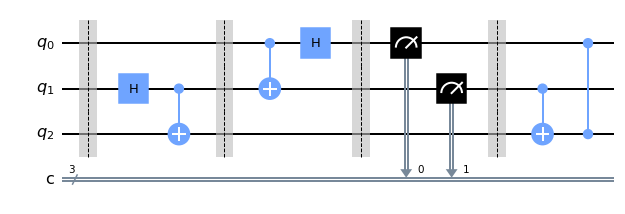

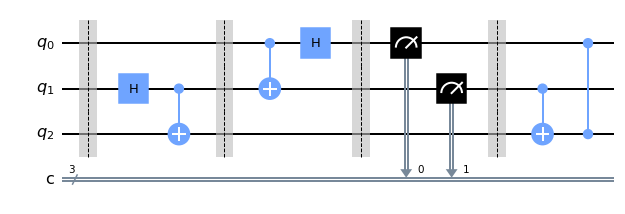

In [36]:
                                        """ Generación del estado aleatorio y circuito  """

#Se crea un circuito de donde se leerá el estado aleatorio guardado
# a,b= al.estado_aleatorio_normal()
# q_0 = QuantumRegister(1,'q') #Basta con un registro cuántico
# estado_inicial=a
# estado_inicial.initialize(a,q_0) #Se inicializa el estado aleatorio que se almacenó en a hacia el circuito inicial para comparar
 
#     """ Proceso de teleportación del estado aleatorio conseguido """

qreg_q = QuantumRegister(3, 'q')  #3 registros cuánticos
creg_c = ClassicalRegister(3, 'c') #3 registros clásicos
circuit = QuantumCircuit(qreg_q, creg_c) #Se crea un circuito utilizando estos registros

#Instrucciones para el circuito
##Inicialización del estado (por defecto todos los estados en qiskit están en |0>)

# circuit.initialize(a,qreg_q[0])   #Se inicializa en el circuito de teleportación el estado aleatorio almacenado 
circuit.barrier(qreg_q[0], qreg_q[1], qreg_q[2]) 

#PROTOCOLO DE TELEPORTACIÓN
##Inicialización de estado de Bell: Se inicia el estado beta_00
circuit.h(qreg_q[1]) # Se pone a q1 en superposición
circuit.cx(qreg_q[1], qreg_q[2]) #Se entrelaza con q2 mediante una compuerta not controlada (cx)
circuit.barrier(qreg_q[0], qreg_q[1], qreg_q[2]) 
circuit.cx(qreg_q[0], qreg_q[1]) #Se entrelaza con q0 (qubit a enviar) mediante la misma operación
circuit.h(qreg_q[0]) #Se pone en superposición este estado resultante
circuit.barrier(qreg_q[0], qreg_q[1], qreg_q[2]) 
circuit.measure(qreg_q[0], creg_c[0])  #Se hace una medición en q0 y q1 haciendo que sus estados colapsen
circuit.measure(qreg_q[1], creg_c[1])
circuit.barrier(qreg_q[0], qreg_q[1], qreg_q[2]) 
##Continuación del protocolo: Colapsar los estados
##Cierre del protocolo
circuit.cx(qreg_q[1], qreg_q[2]) #Se finaliza el protocolo asignando una compuerta cnot para que q2 ajuste su estado en el momento que q0 y q1 comunican el estado resultante que han obtenido, para que así q2 lo ajuste. 
circuit.cz(qreg_q[0], qreg_q[2]) #Se realiza lo mismo con una cz entra q0 y q1.
# circuit.measure(qreg_q[2],creg_c[2]) #Se hace medición del estado q_2 
print("Protocolo de teleportación para el estado generado")
circuit.draw()

In [37]:
                              """Tomografía de estado cuántico (simulada)"""
# Se genera el circuito del estado de tomografía
n_shots=5000
qst_q0 = state_tomography_circuits(circuit, [qreg_q[2]]) #Se llama al circuito de tomografía y se toma el qubit a medir (que en este caso se verá a q2)
#Se manda a ejecutar esta función para su simulación
job = qiskit.execute(qst_q0,Aer.get_backend('qasm_simulator'), shots=n_shots)

print("Simulando ",n_shots, "tiros para el proceso de tomografía")
job_monitor(job)

Simulando  5000 tiros para el proceso de tomografía
Job Status: job has successfully run


In [38]:
#Se hace un recuento de los estados obtenidos tras los 5000 shots. 
fiteo_tomografia_simu = StateTomographyFitter(job.result(), qst_q0) 
# fiteo_tomografia.data #Se muestra la distribución tras pasarlo por cada uno de los operadores   (descomentar si se gusta)

In [39]:
                 """ Inicio de sesión en la cuenta de IBM """
    
provider = IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')
qcomp= provider.get_backend('ibmq_belem') #En este caso se corre en la computadora

ibmqfactory.load_account:WARNING:2021-09-02 06:21:27,514: Credentials are already in use. The existing account in the session will be replaced.


In [40]:
                                "Tomografía de estado cuántico (en computadora cuántica)"
qst_q0_comp = state_tomography_circuits(circuit, [qreg_q[2]]) #Proceso de tomografía sobre q[2] (estado teleportado)

#EJECUCIÓN DE LA TOMOGRAFÍA SOBRE LA COMPUTADORA CON EL NÚMERO DE TIROS MENCIONADO
job_qcomp = qiskit.execute(qst_q0_comp,backend=qcomp, shots=5000)

#VISUALIZACIÓN DEL ESTADO DE LAS CORRIDAS
job_monitor(job_qcomp)

Job Status: job has successfully run


In [41]:
  """Ajuste de la tomografía (de la computadora cuantica)"""
fiteo_tomografia_qcomp = StateTomographyFitter(job_qcomp.result(), qst_q0_comp) 

In [43]:
                                          """Resultados"""

estado_inicial=[1,0]
"""Comparación de matríces de densidad"""
# Se hace el ajuste de tomografía  para obtener la matríz de densidad del estado correspondiente a q_2
#Hace este ajsute mediante el método de mínimos cuadrados (o alguno que se seleccione) y lo ajusta hacia
#la variable rho(q_2)
rho_fit_q2_simu = fiteo_tomografia_simu.fit(method='lstsq') 

"""Medición de la fidelidad """
fidelidad_simu=qi.state_fidelity(rho_fit_q2_simu,qi.DensityMatrix(estado_inicial))

"""Conversión del estado inicial a coordenadas rectangulares"""
rho_estado_inicial= qi.DensityMatrix(estado_inicial)
posicion_estado=al.rho_to_cartesian(rho_estado_inicial)

"""Se transforma la matríz de densidad hacia coordenadas rectangulares """
posicion_simu=al.rho_to_cartesian(rho_fit_q2_simu)

#      """RESULTADOS EN LA COMPUTADORA CUÁNTICA"""

"""Comparación de matríces de densidad"""
rho_fit_q2_qcomp = fiteo_tomografia_qcomp.fit(method='lstsq') 

"""Medición de la fidelidad """
fidelidad_qcomp=qi.state_fidelity(rho_fit_q2_qcomp,qi.DensityMatrix(estado_inicial))

"""Se transforma la matríz de densidad hacia coordenadas rectangulares """

posicion_qcomp=al.rho_to_cartesian(rho_fit_q2_qcomp)

"""Impresión de resultados"""

print("=============================================================")
print(" \t \t Resultados obtenidos : ")
print("============================================================= \n")
print("ρ_inicial = ",qi.DensityMatrix(estado_inicial).__array__(),"\n")
print("ρ_teleportado_simulado=",rho_fit_q2_simu,"\n")
print("ρ_teleportado_qcomp = ", rho_fit_q2_qcomp,"\n")
print("-------------------------------------------------------")
print("Pureza del estado inicial: ",np.real(qi.purity(qi.DensityMatrix(estado_inicial))))
print("Pureza del estado teleportado simualdo :",np.real(qi.purity(rho_fit_q2_simu)),"\n")
print("Pureza del estado teleportado qcomp : ",np.real(qi.purity(rho_fit_q2_qcomp)),"\n" )
print("-------------------------------------------------------")
print("Fidelidad con el proceso simulado : {:.5f}".format(fidelidad_simu))
print("Fidelidad con la computadora cuántica  : {:.5f}".format(fidelidad_qcomp))


 	 	 Resultados obtenidos : 

ρ_inicial =  [[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]] 

ρ_teleportado_simulado= [[ 9.99996440e-01+0.j         -1.59998861e-03+0.00099999j]
 [-1.59998861e-03-0.00099999j  3.55996198e-06+0.j        ]] 

ρ_teleportado_qcomp =  [[0.8718+0.j    0.02  +0.017j]
 [0.02  -0.017j 0.1282+0.j   ]] 

-------------------------------------------------------
Pureza del estado inicial:  1.0
Pureza del estado teleportado simualdo : 1.0 

Pureza del estado teleportado qcomp :  0.7778484799999996 

-------------------------------------------------------
Fidelidad con el proceso simulado : 1.00000
Fidelidad con la computadora cuántica  : 0.87180


In [27]:
estados_file = open("estados_iniciales.txt", "a")
initrho_file= open("initrho.txt", "a")
finalrho_file= open("finalrho.txt", "a")
Pureza_file=   open("pureza.txt", "a")
Fidelidad_file=open("fidelidad.txt", "a")

estados_file.write("\n")
estados_file.write(str(estado_inicial))
initrho_file.write("\n")
initrho_file.write(str(qi.DensityMatrix(estado_inicial)))
finalrho_file.write("\n")
finalrho_file.write(str(rho_fit_q2_qcomp))
Pureza_file.write("\n")
Pureza_file.write(str(np.real(qi.purity(rho_fit_q2_qcomp))))
Fidelidad_file.write("\n")
Fidelidad_file.write(str(fidelidad_qcomp))

estados_file.close()
initrho_file.close()
finalrho_file.close()
Pureza_file.close()
Fidelidad_file.close()


In [44]:
""" Comparación en la esfera de Bloch"""

vectores=[posicion_simu,posicion_qcomp,posicion_estado] #Se guardan en su forma statevector
vectors_color = ['#EBDD1D', '#1D31EB','#EB1D1D'] #Asignación de color

print("Comparación del estado inicial con su parte teleportada (rojo: estado inicial ; amarillo: estado teleportado simulado; azul: estado teleportado en la computadora cuántica)")
#Se imprimen en la esfera de bloch
esfera_simu= bloch_sphere(vectors=vectores,vectors_color=vectors_color,vectors_annotation=False,figsize=(600,600),as_widget=True)
esfera_simu

Comparación del estado inicial con su parte teleportada (rojo: estado inicial ; amarillo: estado teleportado simulado; azul: estado teleportado en la computadora cuántica)


PlotlyWidget({
    'data': [{'line': {'color': 'rgba(235,221,29,1.0)', 'width': 10},
              'mode': 'li…

In [26]:
"""Representación con puntos sobre la esfera de Bloch"""
esfera_simu= bloch_sphere(points=vectores,points_color=vectors_color,vectors_annotation=True,figsize=(600,600),as_widget=True)
esfera_simu

PlotlyWidget({
    'data': [{'marker': {'color': ['rgba(235,221,29,1.0)', 'rgba(29,49,235,1.0)', 'rgba(235,29,…

In [38]:
a=[0 for i in range(10)] 
b=[0 for i in range(10)] 
vec3 = []
rho3 =[]
for i in range(0,10):
    a[i],b[i]=al.estado_aleatorio_normal()
    vec3.append(b[i])
    rho3.append(qi.DensityMatrix(a[i]).__array__())
    
bloch_normal= bloch_sphere(points=vec3,points_color='#189843',figsize=(600,600))



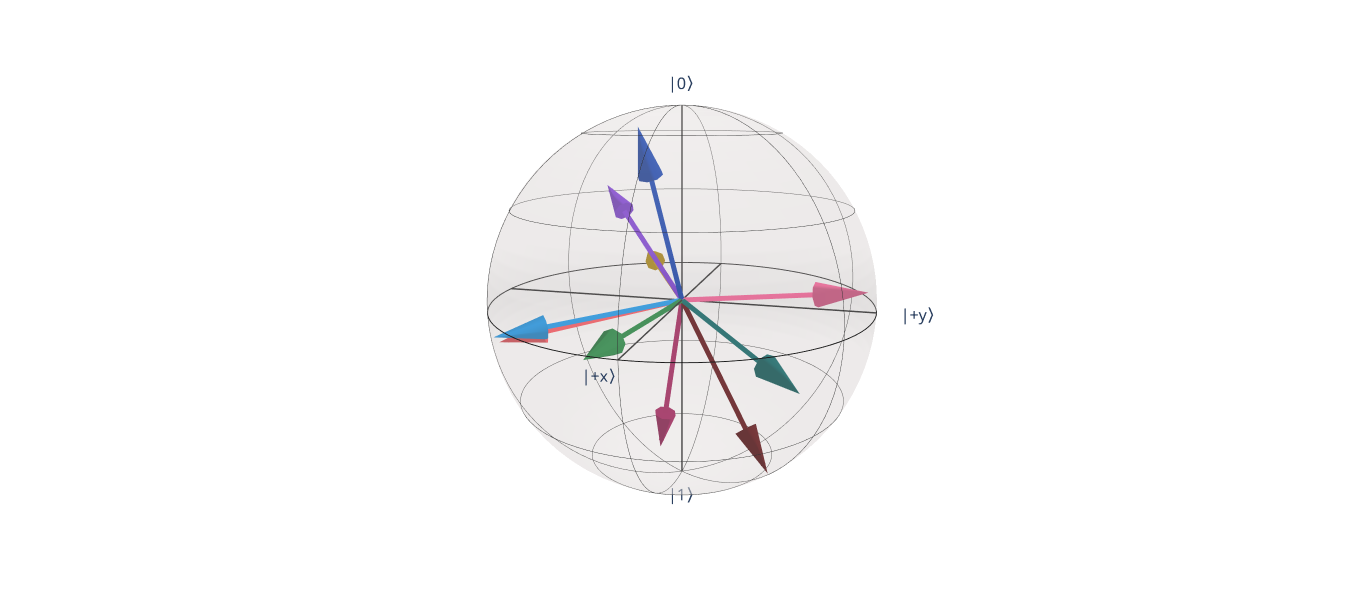

In [42]:
bloch_sphere(vectors=vec3,figsize=(600,600))

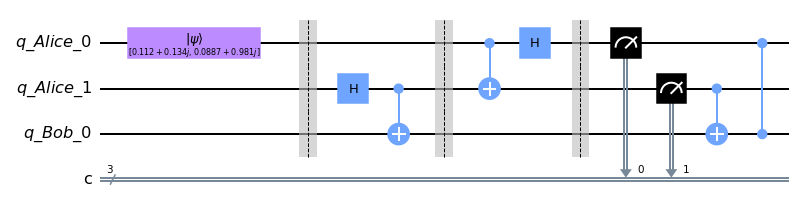

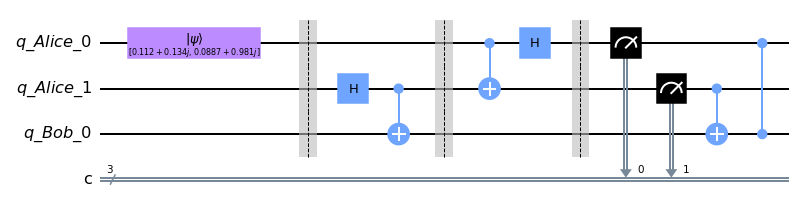

In [62]:
                                        """ Generación del estado aleatorio y circuito  """

#Se crea un circuito de donde se leerá el estado aleatorio guardado
a,b= al.estado_aleatorio_normal()
q_0 = QuantumRegister(1,'q') #Basta con un registro cuántico
estado_inicial=a
# estado_inicial.initialize(a,q_0) #Se inicializa el estado aleatorio que se almacenó en a hacia el circuito inicial para comparar
 
#     """ Proceso de teleportación del estado aleatorio conseguido """

qal = QuantumRegister(2, 'q_Alice')  #3 registros cuánticos
qbo = QuantumRegister(1, 'q_Bob')  #3 registros cuánticos
creg_c = ClassicalRegister(3, 'c') #3 registros clásicos
circuit = QuantumCircuit(qal,qbo, creg_c) #Se crea un circuito utilizando estos registros

#Instrucciones para el circuito
##Inicialización del estado (por defecto todos los estados en qiskit están en |0>)

circuit.initialize(a,qal[0])   #Se inicializa en el circuito de teleportación el estado aleatorio almacenado 
circuit.barrier(qal[0], qal[1], qbo[0]) 

#PROTOCOLO DE TELEPORTACIÓN
##Inicialización de estado de Bell: Se inicia el estado beta_00
circuit.h(qal[1]) # Se pone a q1 en superposición
circuit.cx(qal[1], qbo[0]) #Se entrelaza con q2 mediante una compuerta not controlada (cx)
circuit.barrier(qal[0], qal[1], qbo[0]) 
circuit.cx(qal[0], qal[1]) #Se entrelaza con q0 (qubit a enviar) mediante la misma operación
circuit.h(qal[0]) #Se pone en superposición este estado resultante
circuit.barrier(qal[0], qal[1], qbo[0]) 
##Continuación del protocolo: Colapsar los estados
##Cierre del protocolo
circuit.measure(qal[0], creg_c[0])  #Se hace una medición en q0 y q1 haciendo que sus estados colapsen
circuit.measure(qal[1], creg_c[1])

circuit.cx(qal[1], qbo[0]) #Se finaliza el protocolo asignando una compuerta cnot para que q2 ajuste su estado en el momento que q0 y q1 comunican el estado resultante que han obtenido, para que así q2 lo ajuste. 
circuit.cz(qal[0], qbo[0]) #Se realiza lo mismo con una cz entra q0 y q1.

# # circuit.measure(qreg_q[2],creg_c[2]) #Se hace medición del estado q_2 
# print("Protocolo de teleportación para el estado generado")
circuit.draw()